In [1]:
from netCDF4 import MFDataset,Dataset,num2date,date2num
import numpy as np
import datetime as dt
import xarray as xr
from scipy.interpolate import interp2d, griddata, LinearNDInterpolator, NearestNDInterpolator
import os

IAP_pth='D:/IAP/'
# wnpth='J:/Reanalysis/myGECCO_199201_201712_ztsuv.nc'

### Reading data =======================================
print('!!! Reading data ... !!!')

IAP_temp_=xr.open_mfdataset(IAP_pth+'temp/*.nc',parallel=True).loc[dict(time=slice('1980-01','2022-12'))].temp
IAP_temp=IAP_temp_.values.transpose(0,3,1,2)
# IAP_salt=xr.open_mfdataset(IAP_pth+'salt/*.nc',parallel=True).loc[dict(time=slice('1980-01','2022-12'))].salinity.values.transpose(0,3,1,2)
IAP_uv=xr.open_mfdataset(IAP_pth+'UV/*.nc',parallel=True).loc[dict(time=slice('1980-01','2022-12'))]
# IAP_u,IAP_v=IAP_uv.u.values,IAP_uv.v.values
IAP_u=IAP_uv.u.values.transpose(0,3,1,2)

LAT,LON,DEPTH=IAP_temp_.lat.values,IAP_temp_.lon.values,IAP_temp_.depth_std.values
LAT_uv,LON_uv,DEPTH_uv=IAP_uv.lat.values,IAP_uv.lon.values,IAP_uv.depth.values

!!! Reading data ... !!!


In [18]:
### Create time variables ===========================================
Ref_time='days since 1970-1-1 00:00:00'
TIMES=date2num([dt.datetime(int(str(i)[:4]),int(str(i)[4:6]),15) for i in IAP_temp_['time'].values],Ref_time)

array([ 3666,  3697,  3726,  3757,  3787,  3818,  3848,  3879,  3910,
        3940,  3971,  4001,  4032,  4063,  4091,  4122,  4152,  4183,
        4213,  4244,  4275,  4305,  4336,  4366,  4397,  4428,  4456,
        4487,  4517,  4548,  4578,  4609,  4640,  4670,  4701,  4731,
        4762,  4793,  4821,  4852,  4882,  4913,  4943,  4974,  5005,
        5035,  5066,  5096,  5127,  5158,  5187,  5218,  5248,  5279,
        5309,  5340,  5371,  5401,  5432,  5462,  5493,  5524,  5552,
        5583,  5613,  5644,  5674,  5705,  5736,  5766,  5797,  5827,
        5858,  5889,  5917,  5948,  5978,  6009,  6039,  6070,  6101,
        6131,  6162,  6192,  6223,  6254,  6282,  6313,  6343,  6374,
        6404,  6435,  6466,  6496,  6527,  6557,  6588,  6619,  6648,
        6679,  6709,  6740,  6770,  6801,  6832,  6862,  6893,  6923,
        6954,  6985,  7013,  7044,  7074,  7105,  7135,  7166,  7197,
        7227,  7258,  7288,  7319,  7350,  7378,  7409,  7439,  7470,
        7500,  7531,

In [11]:
### UV interpolation =================================================
print('!!! Interpolating UV ...!!!')

new_u=np.zeros_like(IAP_temp)
# new_v=np.zeros_like(new_u)

T,D,A,O=new_u.shape

def NearesND(lon1, lat1, data, lon2, lat2):

    if len(np.shape(lon1)) == 1 or len(np.shape(lat1)) == 1:
        lon1, lat1 = np.meshgrid(lon1, lat1)
    
    if len(np.shape(lon2)) == 1 or len(np.shape(lat2)) == 1:
        lon2, lat2 = np.meshgrid(lon2, lat2)

    dom_lon_flat = lon1.ravel()
    dom_lat_flat = lat1.ravel()
    linear_filled_flat = data.ravel()

    valid_indices = ~np.isnan(linear_filled_flat)

    NearInterp = NearestNDInterpolator((dom_lon_flat[valid_indices], 
                                     dom_lat_flat[valid_indices]),
                                     linear_filled_flat[valid_indices])
                                     

    neares_filled = NearInterp(lon2, lat2)

    return neares_filled

for t in range(T):
    print(t)
    for d in range(D):
        new_u[t,d]=NearesND(LON_uv, LAT_uv, IAP_u[t,d,:,:], LON, LAT)
        new_v[t,d]=NearesND(LON_uv, LAT_uv, IAP_v[t,d,:,:], LON, LAT)

# del IAP_u, IAP_v



!!! Interpolating UV ...!!!
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


In [17]:
### Writing data =============================================
print('!!! Writing data... !!!')
def myOGCM(nc_save_name,LON,LAT,DEPTH,TIME,Ref_time,values1,values2,values3,values4):
    
    ncfile = Dataset(nc_save_name,mode='w',format='NETCDF4')

    ncfile.createDimension('lat', len(LAT))
    ncfile.createDimension('lon', len(LON))
    ncfile.createDimension('depth',len(DEPTH))
    ncfile.createDimension('time',len(TIME))
    
    ncfile.title='My IAP data '
    
    lat = ncfile.createVariable('lat', np.float32, ('lat',))
    lat.units = 'degrees_north'
    lon = ncfile.createVariable('lon', np.float32, ('lon',))
    lon.units = 'degrees_east'
    depth = ncfile.createVariable('depth', np.float32, ('depth',))
    depth.units = 'depth_m'
    time = ncfile.createVariable('time', np.float64, ('time',))
    time.units=Ref_time
    time.field='time, scalar, series'
    # time.cycle_length=cycle
    
    DATA1 = ncfile.createVariable('temp',np.float64,('time','depth','lat','lon'),compression='zlib') #
    DATA1.units = 'degree_C' 
    DATA1.long_name = 'IAP temp' 
    DATA1.coordinates = "time, depth, lat, lon"
    
    DATA2 = ncfile.createVariable('salt',np.float64,('time','depth','lat','lon'),compression='zlib') 
    DATA2.units = 'g kg-1' 
    DATA2.long_name = 'IAP salt' 
    DATA2.coordinates = "time, depth, lat, lon"

    DATA3 = ncfile.createVariable('u',np.float64,('time','depth','lat','lon'),compression='zlib') 
    DATA3.units = 'meter second-1' 
    DATA3.long_name = 'Eastward velocity' 
    DATA3.coordinates = "time, depth, lat, lon"
    
    DATA4 = ncfile.createVariable('v',np.float64,('time','depth','lat','lon'),compression='zlib') 
    DATA4.units = 'meter second-1' 
    DATA4.long_name = 'Northward velocity' 
    DATA4.coordinates = "time, depth, lat, lon"
    
    # Data.field=Var.field
    lat[:] = LAT
    lon[:] = LON
    depth[:]= DEPTH
    time[:] = TIME 
     
    DATA1[:] = values1
    DATA2[:] = values2
    DATA3[:] = values3
    DATA4[:] = values4

    ncfile.close()

myOGCM(wnpth,LON,LAT,DEPTH,Ref_time,Ref_time,IAP_salt,IAP_temp,new_u,new_v)

(504, 41, 180, 360)

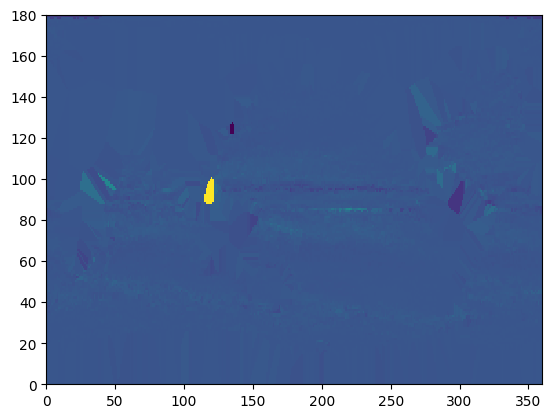

In [10]:
import matplotlib.pyplot as plt
